In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from pyspark.sql import SparkSession

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
spark = SparkSession.builder.appName('test_1').getOrCreate()

In [5]:
df = spark.read.csv('/content/drive/MyDrive/Project/unbalaced_20_80_dataset.csv',inferSchema=True, header=True)

In [6]:
df.show()

+-------+--------------------+--------------+--------+-------------+--------+--------+--------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+------------------+---------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------+------------+-----------+------------------+------------------+-----------+-----------+-----------+--------------------+-------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------------+-------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+----------------+------------------+--------------+--------------+----------------+

In [7]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Flow ID: string (nullable = true)
 |-- Src IP: string (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst IP: string (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: double (nullable = true)
 |-- TotLen Bwd Pkts: double (nullable = true)
 |-- Fwd Pkt Len Max: double (nullable = true)
 |-- Fwd Pkt Len Min: double (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: double (nullable = true)
 |-- Bwd Pkt Len Min: double (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nul

In [9]:
df = df.na.drop('any')

In [10]:
df.groupBy('Label').count().show()

+------+-------+
| Label|  count|
+------+-------+
|  ddos|1294524|
|Benign|6292297|
+------+-------+



### Balance:
Benign: 83% - DDOS: 17%

In [11]:
from pyspark.sql.functions import col,isnan, when, count

In [12]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---+-------+------+--------+------+--------+--------+---------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+----------+----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-

### NO NULLS

In [13]:
df_ddos = df.filter(df['Label']=='ddos')
df_benign = df.filter(df['Label']=='Benign')

In [14]:
oversample_ratio = df_benign.count()/df_ddos.count()

In [15]:
df_ddos_oversampled = df_ddos.sample(withReplacement=True, fraction=oversample_ratio-1, seed=1)

In [16]:
df_final = df_benign.unionAll(df_ddos_oversampled)

In [17]:
df_final.show()

+-------+--------------------+---------------+--------+---------------+--------+--------+--------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+------------------+------------------+---------------+---------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------+------------+------------+------------------+------------------+-----------+-----------+------------+------------------+------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------------+-------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+--------------+---------

In [18]:
df_final.groupBy('Label').count().show()

+------+-------+
| Label|  count|
+------+-------+
|Benign|6292297|
|  ddos|4999488|
+------+-------+



### Balance: 
Benign: 56% - DDOS: 44% 

In [19]:
df_final.count()

11291785

In [20]:
my_cols_df_full = df_final.columns

In [21]:
my_cols_df_full

['_c0',
 'Flow ID',
 'Src IP',
 'Src Port',
 'Dst IP',
 'Dst Port',
 'Protocol',
 'Timestamp',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size 

In [22]:
df_final.show()

+-------+--------------------+---------------+--------+---------------+--------+--------+--------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+------------------+------------------+---------------+---------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------+------------+------------+------------------+------------------+-----------+-----------+------------+------------------+------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------------+-------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+--------------+---------

In [23]:
from pyspark.sql.functions import dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format

In [24]:
df_final.select(df_final['Timestamp']).show()

+--------------------+
|           Timestamp|
+--------------------+
| 20/02/2018 10:36:27|
|04/07/2017 12:15:...|
| 20/02/2018 08:55:58|
| 20/02/2018 11:53:46|
| 20/02/2018 10:06:32|
| 20/02/2018 11:28:42|
| 20/02/2018 12:13:16|
| 20/02/2018 10:16:50|
| 20/02/2018 04:22:35|
| 20/02/2018 08:56:55|
| 20/02/2018 10:36:01|
|03/07/2017 06:39:...|
| 20/02/2018 05:10:09|
| 20/02/2018 02:42:50|
|03/07/2017 08:01:...|
| 20/02/2018 10:38:11|
| 20/02/2018 10:01:49|
|04/07/2017 12:25:...|
| 20/02/2018 11:17:24|
| 20/02/2018 02:54:06|
+--------------------+
only showing top 20 rows



In [25]:
df_final.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Flow ID: string (nullable = true)
 |-- Src IP: string (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst IP: string (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: double (nullable = true)
 |-- TotLen Bwd Pkts: double (nullable = true)
 |-- Fwd Pkt Len Max: double (nullable = true)
 |-- Fwd Pkt Len Min: double (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: double (nullable = true)
 |-- Bwd Pkt Len Min: double (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nul

In [26]:
str_columnList = [item[0] for item in df_final.dtypes if item[1].startswith('string')]

In [27]:
str_columnList

['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Label']

In [28]:
num_cols = []
for i in df_final.columns:
  if i not in str_columnList:
    num_cols.append(i)

In [29]:
num_cols.append('Label')

In [30]:
df_nums = df_final.select(num_cols)

In [31]:
df_nums.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: double (nullable = true)
 |-- TotLen Bwd Pkts: double (nullable = true)
 |-- Fwd Pkt Len Max: double (nullable = true)
 |-- Fwd Pkt Len Min: double (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: double (nullable = true)
 |-- Bwd Pkt Len Min: double (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nullable = true)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: double (nullable = true)
 |-- Flow

### Building the ML Model

In [32]:
df_nums.show()

+-------+--------+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+------------------+------------------+---------------+---------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------+------------+------------+------------------+------------------+-----------+-----------+------------+------------------+------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------------+-------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+--

In [33]:
from pyspark.ml.feature import VectorAssembler

In [34]:
df_nums.columns

In [35]:
assembler = VectorAssembler(inputCols=df_nums.columns[1:-1], outputCol='features')

In [36]:
output = assembler.transform(df_nums)

In [37]:
from pyspark.ml.feature import StringIndexer

In [38]:
indexer = StringIndexer(inputCol='Label',outputCol='LabelIndex')

In [39]:
output_fixed = indexer.fit(output).transform(output)

In [40]:
output_fixed.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: double (nullable = true)
 |-- TotLen Bwd Pkts: double (nullable = true)
 |-- Fwd Pkt Len Max: double (nullable = true)
 |-- Fwd Pkt Len Min: double (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: double (nullable = true)
 |-- Bwd Pkt Len Min: double (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nullable = true)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: double (nullable = true)
 |-- Flow

In [41]:
output_fixed.show()

+-------+--------+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+------------------+------------------+---------------+---------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------+------------+------------+------------------+------------------+-----------+-----------+------------+------------------+------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------------+-------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+--

In [42]:
final_data = output_fixed.select(['features','LabelIndex'])

In [43]:
final_data.show()

+--------------------+----------+
|            features|LabelIndex|
+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[56889.0,3389.0,6...|       0.0|
|[51263.0,443.0,6....|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,17...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,17...|       0.0|
|[57775.0,3389.0,6...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[49411.0,80.0,6.0...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[52095.0,80.0,6.0...|       0.0|
+--------------------+----------+
only showing top 20 rows



In [44]:
final_data = final_data.na.drop()
final_data.show()

+--------------------+----------+
|            features|LabelIndex|
+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[56889.0,3389.0,6...|       0.0|
|[51263.0,443.0,6....|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,17...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,17...|       0.0|
|[57775.0,3389.0,6...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[49411.0,80.0,6.0...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[52095.0,80.0,6.0...|       0.0|
+--------------------+----------+
only showing top 20 rows



In [45]:
output_fixed.count()

11291785

In [46]:
final_data_2 = final_data.sample(0.001,3)

In [47]:
train_data, test_data = final_data.randomSplit([7.,3.])

### Using Tree Based models and Logistic regression

In [48]:
final_data.show()

+--------------------+----------+
|            features|LabelIndex|
+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[56889.0,3389.0,6...|       0.0|
|[51263.0,443.0,6....|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,17...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,17...|       0.0|
|[57775.0,3389.0,6...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[49411.0,80.0,6.0...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[52095.0,80.0,6.0...|       0.0|
+--------------------+----------+
only showing top 20 rows



In [49]:
train_data.show()

+--------------------+----------+
|            features|LabelIndex|
+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
+--------------------+----------+
only showing top 20 rows



In [59]:
test_data.show()

+--------------------+----------+
|            features|LabelIndex|
+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
+--------------------+----------+
only showing top 20 rows



In [56]:
train_data.groupBy('LabelIndex').count().show()

+----------+-------+
|LabelIndex|  count|
+----------+-------+
|       0.0|4405420|
|       1.0|3498658|
+----------+-------+



In [57]:
test_data.groupBy('LabelIndex').count().show()

+----------+-------+
|LabelIndex|  count|
+----------+-------+
|       0.0|1886877|
|       1.0|1500830|
+----------+-------+



In [50]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, LogisticRegression

In [51]:
dt = DecisionTreeClassifier(labelCol='LabelIndex',featuresCol='features')
rf = RandomForestClassifier(numTrees=100,labelCol='LabelIndex',featuresCol='features')
gbt = GBTClassifier(labelCol='LabelIndex',featuresCol='features')

In [52]:
#gpu_info = !nvidia-smi
#gpu_info = '\n'.join(gpu_info)
#if gpu_info.find('failed') >= 0:
#  print('Not connected to a GPU')
#else:
#  print(gpu_info)

Not connected to a GPU


In [53]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


### 1) Decision Tree

In [60]:
dt_model = dt.fit(train_data)

In [ ]:
#rf_model = rf.fit(df_train)
#gb_model = gbt.fit(df_train)

In [61]:
dt_preds = dt_model.transform(test_data)

In [62]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [63]:
my_binary_eval = BinaryClassificationEvaluator(labelCol='LabelIndex')

In [67]:
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="LabelIndex", predictionCol="prediction")

In [68]:
acc_dt = evaluatorMulti.evaluate(dt_preds, {evaluatorMulti.metricName: "accuracy"})

In [69]:
acc_dt

0.9914210408397184

In [73]:
my_binary_eval = BinaryClassificationEvaluator(labelCol='LabelIndex')

In [74]:
auc_dt = my_binary_eval.evaluate(dt_preds)

In [75]:
auc_dt

0.9964127843414693

In [76]:
f1_dt = evaluatorMulti.evaluate(dt_preds, {evaluatorMulti.metricName: "f1"})
f1_dt

0.9914264699577182

In [72]:
dt_preds.show()

+--------------------+----------+-----------------+--------------------+----------+
|            features|LabelIndex|    rawPrediction|         probability|prediction|
+--------------------+----------+-----------------+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|[3485682.0,542.0]|[0.99984453093088...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[3485682.0,542.0]|[0.99984453093088...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[251748.0,5617.0]|[0.97817496551590...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[251748.0,5617.0]|[0.97817496551590...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[251748.0,5617.0]|[0.97817496551590...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[251748.0,5617.0]|[0.97817496551590...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[251748.0,5617.0]|[0.97817496551590...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[251748.0,5617.0]|[0.97817496551590...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[251748.0,5617.0]|[0.97817496551590...|    

### 2) Random Forest

In [78]:
rf_model = rf.fit(train_data)
rf_preds = dt_model.transform(test_data)
acc_rf = evaluatorMulti.evaluate(rf_preds, {evaluatorMulti.metricName: "accuracy"})
auc_rf = my_binary_eval.evaluate(rf_preds)
f1_rf = evaluatorMulti.evaluate(rf_preds, {evaluatorMulti.metricName: "f1"})
print('\n')
print(f"accuracy: {acc_rf}")
print('\n')
print(f"auc score: {auc_rf}")
print('\n')
print(f"f1-score: {f1_rf}")



accuracy: 0.9914210408397184


auc score: 0.9964127843414693


f1-score: 0.9914264699577182


In [82]:
rf_preds.show()

+--------------------+----------+-----------------+--------------------+----------+
|            features|LabelIndex|    rawPrediction|         probability|prediction|
+--------------------+----------+-----------------+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|[3485682.0,542.0]|[0.99984453093088...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[3485682.0,542.0]|[0.99984453093088...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[251748.0,5617.0]|[0.97817496551590...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[251748.0,5617.0]|[0.97817496551590...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[251748.0,5617.0]|[0.97817496551590...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[251748.0,5617.0]|[0.97817496551590...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[251748.0,5617.0]|[0.97817496551590...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[251748.0,5617.0]|[0.97817496551590...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[251748.0,5617.0]|[0.97817496551590...|    

In [80]:
rf_model.featureImportances

SparseVector(79, {0: 0.0181, 1: 0.0255, 2: 0.0064, 3: 0.0126, 4: 0.0232, 5: 0.0171, 6: 0.0227, 7: 0.0114, 8: 0.0268, 9: 0.012, 10: 0.0529, 11: 0.0264, 12: 0.0079, 13: 0.0143, 14: 0.0025, 15: 0.0022, 16: 0.0066, 17: 0.0173, 18: 0.008, 19: 0.0019, 20: 0.016, 21: 0.0085, 22: 0.0089, 23: 0.0089, 24: 0.0042, 25: 0.0092, 26: 0.004, 27: 0.0007, 28: 0.0026, 29: 0.0009, 30: 0.0007, 31: 0.0025, 32: 0.0006, 33: 0.0001, 36: 0.0271, 37: 0.0212, 38: 0.0167, 39: 0.0049, 40: 0.0085, 41: 0.0223, 42: 0.0025, 43: 0.0115, 44: 0.0069, 45: 0.0011, 46: 0.0059, 47: 0.0, 48: 0.0166, 49: 0.0255, 50: 0.0016, 51: 0.0062, 52: 0.0027, 53: 0.0031, 54: 0.0079, 55: 0.0334, 56: 0.0093, 63: 0.0235, 64: 0.0089, 65: 0.0067, 66: 0.0089, 67: 0.0612, 68: 0.0888, 69: 0.008, 70: 0.1693, 71: 0.0002, 72: 0.0, 73: 0.0001, 74: 0.0006, 75: 0.002, 76: 0.0, 77: 0.002, 78: 0.0013})

In [87]:
df_nums.columns[1:-1]

['Src Port',
 'Dst Port',
 'Protocol',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Fwd By

In [88]:
len(df_nums.columns[1:-1])

79

In [97]:
len(rf_model.featureImportances)

79

In [98]:
cols_name = df_nums.columns[1:-1]


In [102]:
feature_importance = []
for i in rf_model.featureImportances:
  feature_importance.append(i)

In [109]:
df_feat_imp = pd.DataFrame({'Feature Name': cols_name, 'Feature Importance':feature_importance})

In [110]:
df_feat_imp.index = df_feat_imp['Feature Name']

In [112]:
df_feat_imp.drop('Feature Name',inplace=True,axis=1)

In [115]:
df_feat_imp.sort_values(by='Feature Importance',ascending=False).head(20)

,Feature Importance
Feature Name,
Fwd Seg Size Min,0.169268
Init Bwd Win Byts,0.088753
Init Fwd Win Byts,0.061156
Fwd Pkt Len Mean,0.052888
Fwd Seg Size Avg,0.033443
Fwd Header Len,0.027124
Fwd Pkt Len Max,0.026827
Fwd Pkt Len Std,0.026449
Dst Port,0.025524


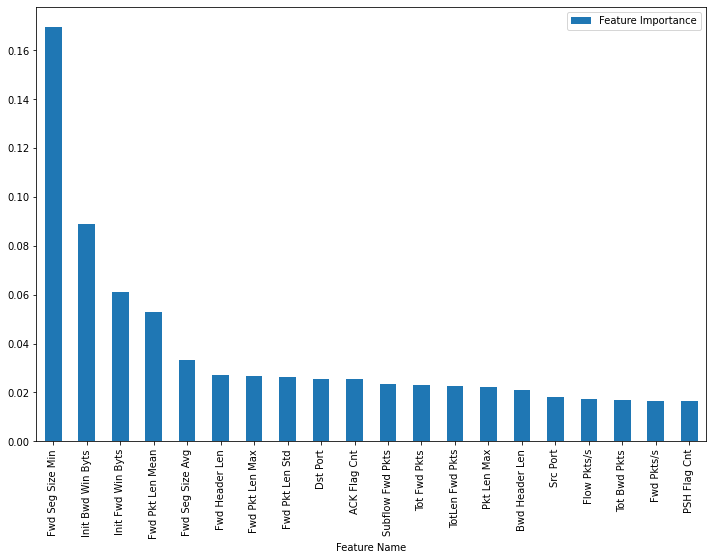

In [116]:
df_feat_imp.sort_values(by='Feature Importance',ascending=False).head(20).plot(kind='bar',figsize=(12,8))